# Tutorial For Creating A Time-Series From ICON-Outputs

This is a small tutorial for how to use the ICON_TS class to generate a time series of statistical values (mean, std etc.) from all files and time steps during an ICON simulation.

In [13]:
import glob
import geopandas as gpd
import numpy as np
import pyvista as pv
pv.set_jupyter_backend('static')

# Import the time series class from its file. It internally relies on the imesh class from the icon2vtk file so this needs to be available
from ICON_Time_Series import ICON_TS

You need to provide the following paths to the class constructor:

* A list of filepaths which point to the ICON output file (.nc)
* A path to the external parameter file used
* A path tohe grid file describing the geometry
* A polygon file used to limit the area for which the time series will be computed (for example the area of the Hintereisferner from RGI)

In [14]:
# set path to dir containing the ICON output files
filepaths = glob.glob(r"G:\NCs\*.nc") # Here we use a directory with six ICON outputs
print(filepaths)

# Adapt paths to the location of the files with external parameters and grid
fext = r"../../Data/external_parameter_icon_hef_DOM01_tiles.nc"
fgrid = r"../../Data/hef_51m_DOM01.nc"

# Set path to the polygon used to limit the grid (glacier shp or else)
gdf = gpd.read_file("../../Data/test.shp")
polygon = gdf.geometry.union_all()  # merge multiple features if needed

['G:\\NCs\\LES_51m_ml_0001.nc', 'G:\\NCs\\LES_51m_ml_0002.nc', 'G:\\NCs\\LES_51m_ml_0003.nc', 'G:\\NCs\\LES_51m_ml_0004.nc', 'G:\\NCs\\LES_51m_ml_0005.nc', 'G:\\NCs\\LES_51m_ml_0006.nc']


## Initializing A Time Series Object

To initialize a class object for the time series, just call the constructor and provide him with the files for the grid, external parameters and outputs together with the number of layers which the 3D geometry should have (this influences computing time).

The constructor automatically uses the imesh class (from icon2vtk.py) to generate an instance of the imesh object which is stored in the time series object. This allows the user to generate multiple time series (different variables or slices) without needing to reinitialize a 3D mesh object.

In [15]:
TS1 = ICON_TS(fgrid=fgrid, fext=fext, nlayers=50, filepaths=filepaths)

Mesh Object Generated In 29.217792510986328 Seconds...


The 3D geometry is stored in the cmesh attribute of the TS class. Since it is a vtk data stucture, it can be plotted with pyvista to check if the mesh generation worked correctly.

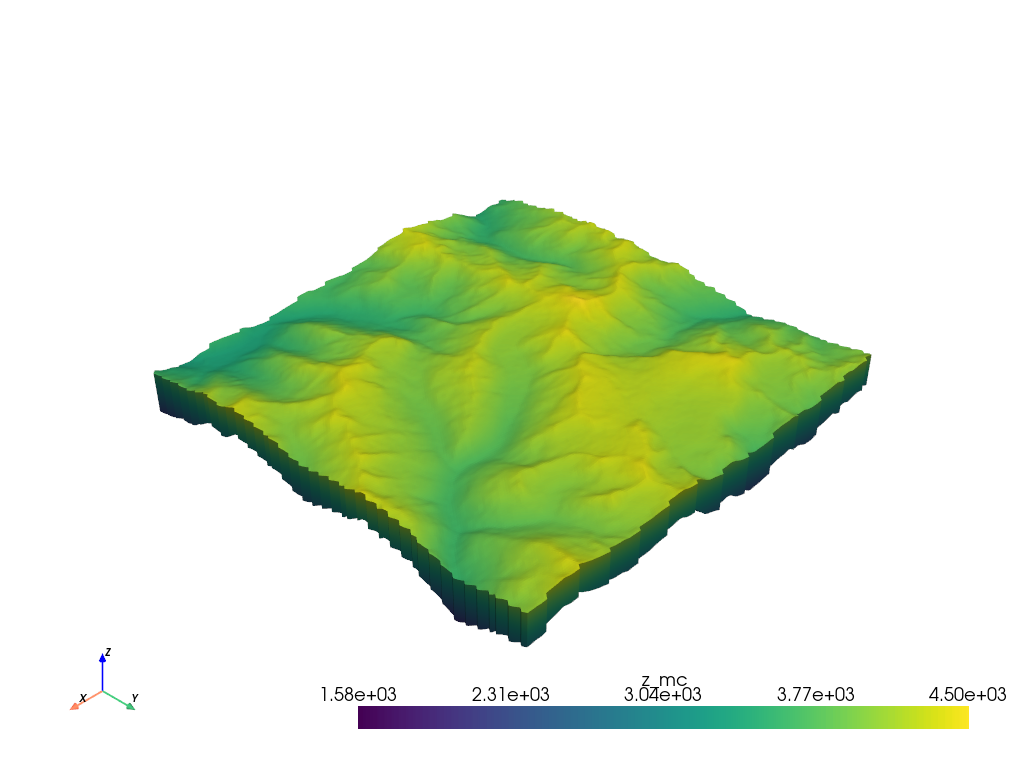

In [16]:
TS1.cmesh.plot()

## Generating A Time Series

To generate a time series, just call the  `.generate_time_series()` function from your object. You need to provide at least the variable name for which you want to generate the time series and the `plane` argument. For this either use "surface" if you want to compute the time series on the ground or a height values (for example 2500) to use a plane generated at that height. If you want to limit the area for which the series is computed, also provide the `polygon` argument. Finally you can use the `value_limits` argument to exclude all cells outside of this interval from the computation. This is especially useful if you know that edge cells have zeros which should not be included. The return from this function is a pandas dataframe which can further be processed and automatically saved with the `save_as` argument.


**A little remark:**
This function works basically like the `main()` function from the icon_vtk_slice.py file. The reason for wrapping it into a class function here is mainly that we can use the `add_variable()` functions already defined in the imesh class instead of copying and adapting the function like in icon_vtk_slice.py for every variable of interest. Also these functions work on a simply pyvista unstructured grid in icon_vtk_slice.py while here we want to call them on a custom imesh-object. Note that using the height mode and not "surface" will take a little longer than surface mode since the mesh is sliced repeatedly in the `generate_time_series()` function. This could have been avoided by slicing once and computing the statistics on the sliced mesh. But this would not allow to use the `add_variable()` function from the imesh-object.

In [18]:
# Test with surface temperature "t_sk"
df1 = TS1.generate_time_series(variable="t_sk", polygon=polygon, plane="surface", value_limits=[1, np.inf])
print(df1.head(5))

100%|██████████| 6/6 [00:13<00:00,  2.29s/it]

                date        mean       var         min         max
0  20230829 04:00:00  274.433838  6.563953  267.370453  280.282074
1  20230829 05:00:00  274.232086  6.182586  267.120575  279.890259
2  20230829 06:00:00  274.461243  7.467894  266.008850  280.355438
3  20230829 07:00:00  275.426514  5.741451  269.627716  280.940765
4  20230829 08:00:00  276.311890  5.604803  271.640472  281.930756


In [19]:
# Test with temperature at 2500 meters
df2 = TS1.generate_time_series(variable="temp", plane=2500, value_limits=[1, np.inf])
print(df2.head(5))

100%|██████████| 6/6 [01:30<00:00, 15.01s/it]

                date        mean        var         min         max
0  20230829 04:00:00  232.006840  23.931951  224.116028  241.472366
1  20230829 05:00:00  231.790707  26.048164  224.543732  241.587036
2  20230829 06:00:00  231.594179  29.280364  223.909454  241.642807
3  20230829 07:00:00  231.547546  32.331193  223.076889  241.662720
4  20230829 08:00:00  231.546175  35.011105  222.407486  241.820023
